In [144]:
#%pip install numpy pandas matplotlib scikit-learn tensorflow seaborn folium xgboost

In [145]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [146]:
SEQUENCE_LENGTH = 30

#numerical_cols =  [
#    'soil_mean',  'rain_mean',
#    'temp_mean',  'humi_mean',
#    'geo_mean', 'lat_mean', 'lng_mean', 'geo_std',
#]

numerical_cols =  [
    'soil_mean',  'rain_mean',
    'temp_mean',  'humi_mean',
    'geo_mean', 'geo_std',
]

In [147]:
df1 = pd.read_csv("../../data/dev101_resample10T.csv")
df2 = pd.read_csv("../../data/dev102_resample10T.csv")

df_all = pd.concat([df1, df2], ignore_index=True)
#df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values(by='timestamp').reset_index(drop=True)
df_all

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,geo_std
0,2025-05-02 11:40:00,101,28.807142,0.0,34.483864,63.477869,10.403310,3.600070
1,2025-05-02 11:40:00,102,22.200001,0.0,34.717920,62.513730,7.895913,5.625963
2,2025-05-02 11:50:00,102,22.203572,0.0,34.847077,61.514394,9.278016,7.178730
3,2025-05-02 11:50:00,101,28.796363,0.0,34.705092,63.005772,11.076278,4.215530
4,2025-05-02 12:00:00,101,28.757143,0.0,35.428349,63.029602,12.472494,3.210523
...,...,...,...,...,...,...,...,...
6516,2025-06-29 20:00:00,101,27.913043,0.0,29.834574,78.178799,10.483214,6.667808
6517,2025-06-29 20:10:00,101,27.900000,0.0,29.834822,78.360775,10.094160,7.053967
6518,2025-06-29 20:10:00,102,25.600000,0.0,29.742026,78.720270,8.012238,5.920143
6519,2025-06-29 20:20:00,101,27.900000,0.0,29.572938,79.303974,7.666770,2.594961


In [148]:
print(df_all['devID'].value_counts())

devID
102    3336
101    3185
Name: count, dtype: int64


In [149]:
print(df_all.columns)

Index(['timestamp', 'devID', 'soil_mean', 'rain_mean', 'temp_mean',
       'humi_mean', 'geo_mean', 'geo_std'],
      dtype='object')


In [150]:

# สร้าง Scaler และฟิตข้อมูล
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_all[numerical_cols])

# เพิ่มคอลัมน์ scaled กลับเข้า DataFrame
for i, col in enumerate(numerical_cols):
    df_all[f'scaled_{col}'] = scaled_values[:, i]

# Save scaler (สำหรับใช้งานจริงในอนาคต)
joblib.dump(scaler, 'scaler4.save')


['scaler4.save']

In [151]:
def create_sequences_by_device(df, sequence_length, numerical_cols, dev_ids=None, return_index=False):
    """
    สร้าง sequence สำหรับแต่ละ device (devID)
    Args:
        df: DataFrame ที่เตรียมข้อมูลแล้ว
        sequence_length: ความยาว sequence
        numerical_cols: รายชื่อคอลัมน์ feature
        dev_ids: รายชื่อ devID ที่ต้องการ (None = ทุก devID)
        return_index: คืนค่า original index ของแถวสุดท้ายในแต่ละ sequence หรือไม่
    Returns:
        sequences: np.array (num_seq, seq_len, num_feat)
        device_ids: รายชื่อ devID ของแต่ละ sequence
        timestamps: timestamp สุดท้ายของแต่ละ sequence
        (option) last_indices: index ของแถวสุดท้ายในแต่ละ sequence (ใน df)
    """
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    for dev_id, group in groupby_obj:
        if dev_ids is not None and dev_id not in dev_ids:
            continue
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values
        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1])
            if return_index:
                last_indices.append(idx_vals[i + sequence_length - 1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps

# ตัวอย่างการใช้งานปกติ
X_seq, device_ids, seq_timestamps = create_sequences_by_device(df_all, SEQUENCE_LENGTH, numerical_cols)



In [152]:
'''
n = len(X_seq)
train_size = int(n * 0.9)
val_size = int(n * 0.1)

X_train = X_seq[:train_size]
X_val = X_seq[train_size:train_size + val_size]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")
'''
X_train = X_seq

In [153]:
n_features = len(numerical_cols)
input_shape = (SEQUENCE_LENGTH, n_features)
'''
# Encoder
inputs = Input(shape=input_shape, name='Input_Sequence') 
x = LSTM(128, return_sequences=True, name='Encoder_LSTM_1')(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = LSTM(64, return_sequences=False, name='Encoder_LSTM_2')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Latent Representation (Bridge)
x = RepeatVector(SEQUENCE_LENGTH, name='Repeat_Latent')(x)

# Decoder
x = LSTM(64, return_sequences=True, name='Decoder_LSTM_1')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = LSTM(128, return_sequences=True, name='Decoder_LSTM_2')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

# Output Layer
outputs = TimeDistributed(Dense(n_features), name='Output_Sequence')(x)
model = Model(inputs, outputs, name='LSTM_Autoencoder')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

'''
# Encoder
inputs = Input(shape=input_shape) 
x = LSTM(128, return_sequences=True)(inputs)  # Layer 1
x = LSTM(64, return_sequences=False)(x)        # Layer 2

# Bridge
x = RepeatVector(SEQUENCE_LENGTH)(x)           # Layer 3

# Decoder
x = LSTM(64, return_sequences=True)(x)         # Layer 4
x = LSTM(128, return_sequences=True)(x)        # Layer 5

# Output Layer
outputs = TimeDistributed(Dense(n_features))(x)  # Layer 6

# Model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 30, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 6)          │           774 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,142 (981.02 KB)

 Trainable params: 251,142 (981.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0510 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0088 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0061 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0053 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0052 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0047 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0046 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0042 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 9/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0041 - val_loss: 0.0041 - learning_rate: 0.0010


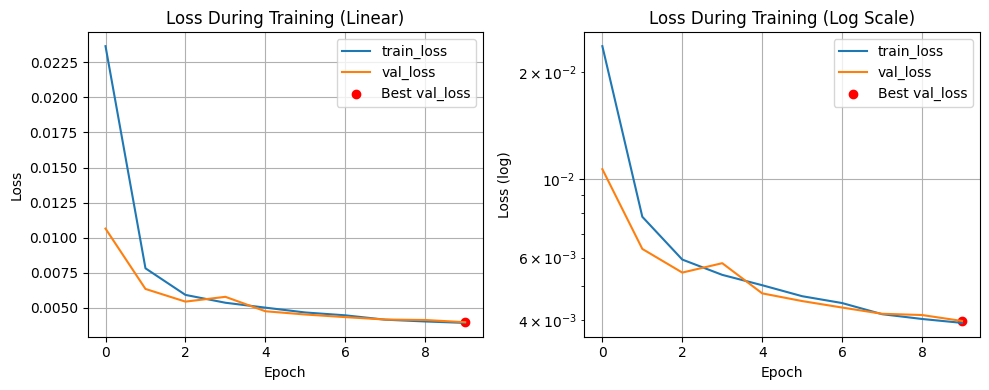

Best epoch: 10, Best val_loss: 0.003975
Loss history saved to train_loss_history.csv


In [154]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=10, #60
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save model
model.save('lstm_autoencoder_model4.h5')

# Save loss history to CSV
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df.to_csv('train_loss_history.csv', index=False)

# Plot loss (linear and log scale)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss During Training (Linear)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.title('Loss During Training (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log)')
plt.grid(True)

# Mark best epoch
best_epoch = int(np.argmin(history.history['val_loss']))
plt.subplot(1, 2, 1)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', label='Best val_loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Best epoch: {best_epoch+1}, Best val_loss: {history.history['val_loss'][best_epoch]:.6f}")
print("Loss history saved to train_loss_history.csv")


# Test

In [155]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA

df1 = pd.read_csv("../../data/dev101_resample10T.csv")
df2 = pd.read_csv("../../data/dev102_resample10T.csv")

df_test = pd.concat([df1, df2], ignore_index=True)
#df_all = pd.read_csv("../../data/devAll2_prepared.csv")

# แปลง timestamp และเรียงลำดับ
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)
df_test

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,geo_std
0,2025-05-02 11:40:00,101,28.807142,0.0,34.483864,63.477869,10.403310,3.600070
1,2025-05-02 11:40:00,102,22.200001,0.0,34.717920,62.513730,7.895913,5.625963
2,2025-05-02 11:50:00,102,22.203572,0.0,34.847077,61.514394,9.278016,7.178730
3,2025-05-02 11:50:00,101,28.796363,0.0,34.705092,63.005772,11.076278,4.215530
4,2025-05-02 12:00:00,101,28.757143,0.0,35.428349,63.029602,12.472494,3.210523
...,...,...,...,...,...,...,...,...
6516,2025-06-29 20:00:00,101,27.913043,0.0,29.834574,78.178799,10.483214,6.667808
6517,2025-06-29 20:10:00,101,27.900000,0.0,29.834822,78.360775,10.094160,7.053967
6518,2025-06-29 20:10:00,102,25.600000,0.0,29.742026,78.720270,8.012238,5.920143
6519,2025-06-29 20:20:00,101,27.900000,0.0,29.572938,79.303974,7.666770,2.594961


In [156]:
#df_test = df_test[df_test['devID'] == 101]  # devID เป็น int ใน df_test
df_original_features = df_test.copy()

df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test.sort_values(by='timestamp').reset_index(drop=True)

scaler = joblib.load('scaler4.save')

missing_cols = [col for col in numerical_cols if col not in df_test.columns]
if missing_cols:
    raise ValueError(f"Missing columns in input CSV: {missing_cols}")

# โหลด MinMaxScaler ที่เทรนไว้
scaled_values = scaler.transform(df_test[numerical_cols])
for i, col in enumerate(numerical_cols):
    df_test[f'scaled_{col}'] = scaled_values[:, i]

# === sequence for predict ===
def create_sequences(df, sequence_length, numerical_cols):
    sequences, device_ids, timestamps = [], [], []
    # เก็บ index เริ่มต้นของแต่ละ sequence เพื่อเชื่อมโยงกับ df_test
    start_indices = []

    for dev_id, group in df.groupby('devID'):
        group = group.sort_values('timestamp')
        values = group[[f'scaled_{col}' for col in numerical_cols]].values
        time_vals = group['timestamp'].values
        
        # เพิ่มคอลัมน์ original_index เพื่อให้สามารถเชื่อมโยงกลับไปยัง df_test ได้
        group = group.reset_index(drop=False).rename(columns={'index': 'original_df_index'})

        for i in range(len(values) - sequence_length + 1):
            sequences.append(values[i:i + sequence_length])
            device_ids.append(dev_id)
            timestamps.append(time_vals[i + sequence_length - 1]) # timestamp ของจุดสุดท้ายใน sequence
            start_indices.append(group['original_df_index'].iloc[i + sequence_length - 1]) # เก็บ original index ของจุดสุดท้าย

    return np.array(sequences), device_ids, timestamps, start_indices

# สร้าง sequence
X_seq_test, device_ids_test, timestamps_test, start_indices_test = create_sequences(df_test, SEQUENCE_LENGTH, numerical_cols)

# === 5. โหลดโมเดลและ predict ===
model = load_model('lstm_autoencoder_model4.h5', compile=False)
X_pred = model.predict(X_seq_test)

# === 6. คำนวณ reconstruction error ===
reconstruction_error = np.mean(np.mean(np.square(X_seq_test - X_pred), axis=1), axis=1)

# === 7. สร้าง DataFrame เก็บผล ===
df_results = pd.DataFrame({
    'devID': device_ids_test,
    'timestamp': timestamps_test,
    'reconstruction_error': reconstruction_error,
    'original_df_index': start_indices_test # เพิ่มคอลัมน์นี้เพื่อ merge กับ df_original_features
})


202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [157]:

# === 8. คำนวณ thresholds และกำหนด Anomaly Level ===
threshold_warning = np.percentile(df_results['reconstruction_error'], 95)
threshold_critical = np.percentile(df_results['reconstruction_error'], 99.5)
#threshold_warning = 0.00737
#threshold_critical = 0.01530

def classify_anomaly(err):
    if err > threshold_critical:
        return 'critical'
    elif err > threshold_warning:
        return 'warning'
    else:
        return 'normal'

df_results['anomaly_level'] = df_results['reconstruction_error'].apply(classify_anomaly)

print(f"95th percentile (Warning) threshold = {threshold_warning:.5f}")
print(f"99th percentile (Critical) threshold = {threshold_critical:.5f}")
print("\n--- Anomaly Level Counts ---")
print(df_results['anomaly_level'].value_counts())

95th percentile (Warning) threshold = 0.00931
99th percentile (Critical) threshold = 0.01689

--- Anomaly Level Counts ---
anomaly_level
normal      6139
warning      291
critical      33
Name: count, dtype: int64


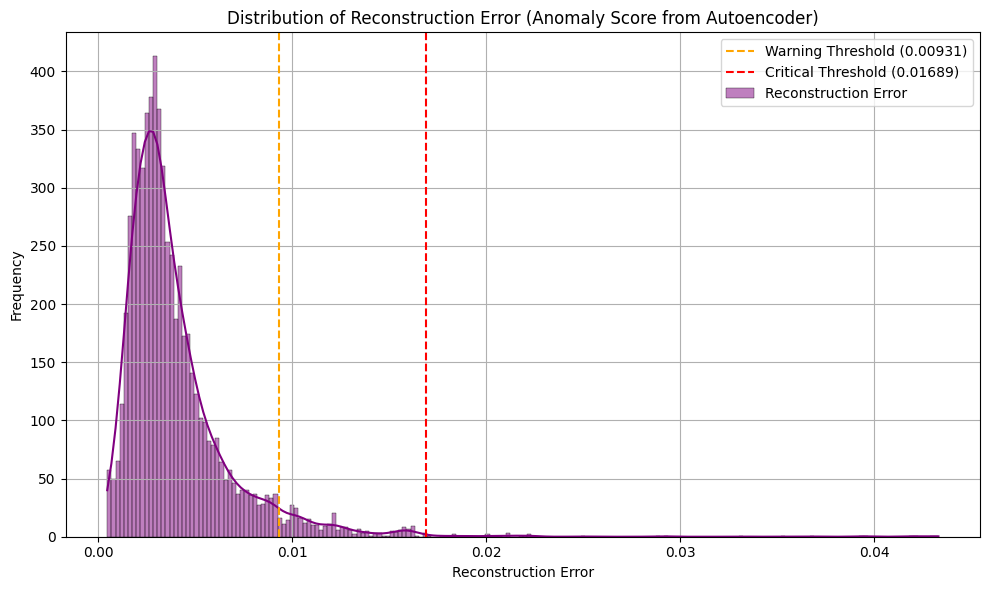

In [158]:
# --- การรวมข้อมูลเพื่อการวิเคราะห์เพิ่มเติม ---

df_original_features = df_original_features.loc[:, ~df_original_features.columns.duplicated()]

if 'original_df_index' not in df_original_features.columns:
    df_original_features = df_original_features.reset_index().rename(columns={'index': 'original_df_index'})

df_original_features['timestamp'] = pd.to_datetime(df_original_features['timestamp'])

# Merge ข้อมูล
df_analysis = pd.merge(df_results, df_original_features, on=['devID', 'timestamp', 'original_df_index'], how='left')

if df_analysis.isnull().any().any():
    print("\nWarning: Missing values found in merged DataFrame. Ensure timestamps and devIDs match for accurate feature analysis.")

palette_anomaly = {'normal': 'green', 'warning': 'orange', 'critical': 'red'}

# --- 1. Distribution of Reconstruction Error ---
plt.figure(figsize=(10, 6))
sns.histplot(df_results['reconstruction_error'], bins=200, kde=True, color='purple', label='Reconstruction Error')
plt.axvline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axvline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Distribution of Reconstruction Error (Anomaly Score from Autoencoder)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ahmad\AppData\Local\Temp\ipykernel_16332\4259196113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)


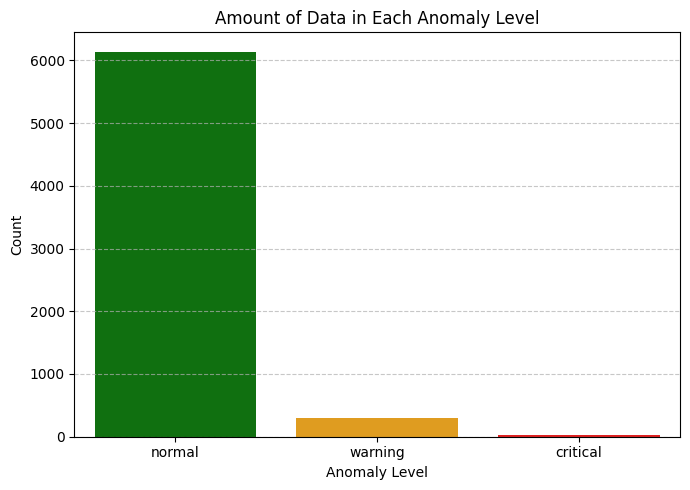

In [159]:
# --- 2. Anomaly Level Counts ---
plt.figure(figsize=(7, 5))
sns.countplot(data=df_results, x='anomaly_level', order=['normal', 'warning', 'critical'], palette=palette_anomaly)
plt.title('Amount of Data in Each Anomaly Level')
plt.xlabel('Anomaly Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

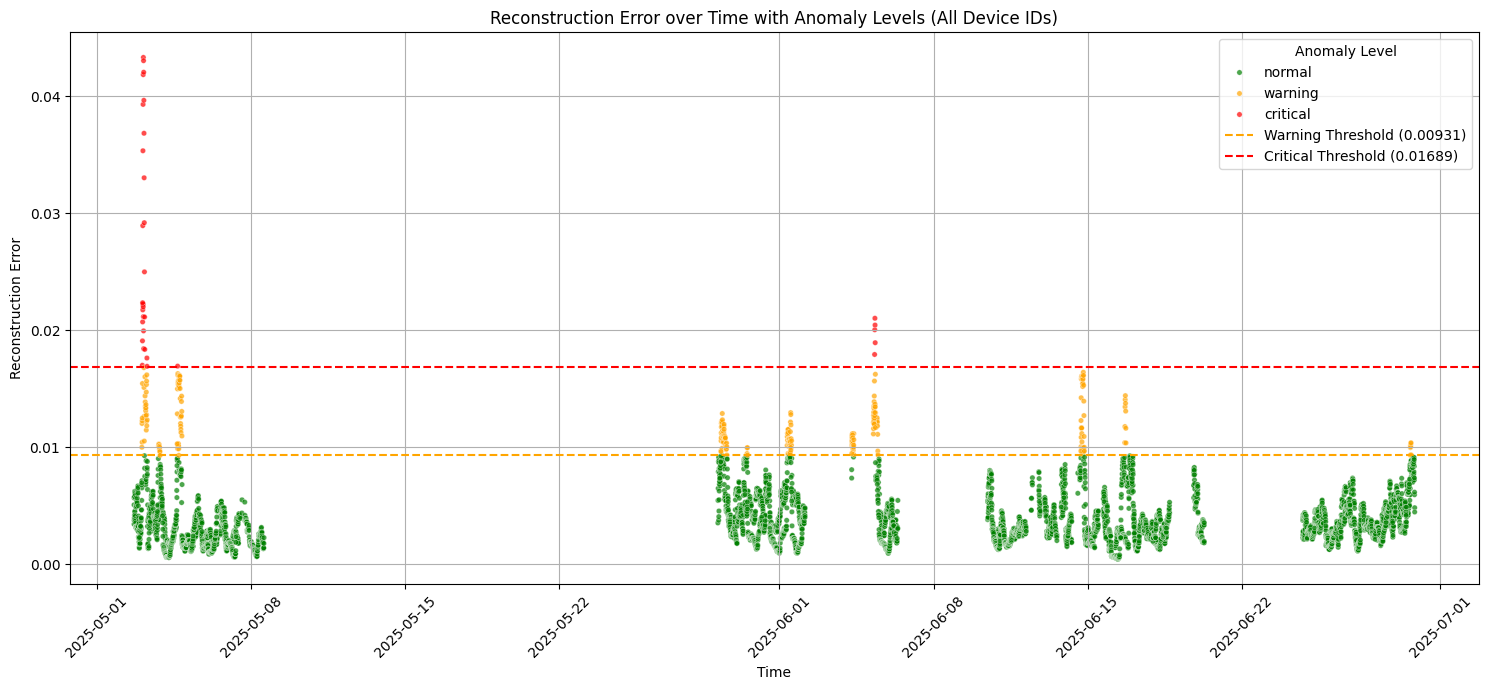

In [160]:
# --- 3. Reconstruction Error Over Time with Anomaly Levels (All Devices) ---
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=df_results, x='timestamp', y='reconstruction_error',
    hue='anomaly_level', palette=palette_anomaly, alpha=0.7, s=15,
    hue_order=['normal', 'warning', 'critical']
)
plt.axhline(threshold_warning, color='orange', linestyle='--', label=f'Warning Threshold ({threshold_warning:.5f})')
plt.axhline(threshold_critical, color='red', linestyle='--', label=f'Critical Threshold ({threshold_critical:.5f})')
plt.title('Reconstruction Error over Time with Anomaly Levels (All Device IDs)')
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.xticks(rotation=45)
plt.legend(title='Anomaly Level')
plt.tight_layout()
plt.grid(True)
plt.show()


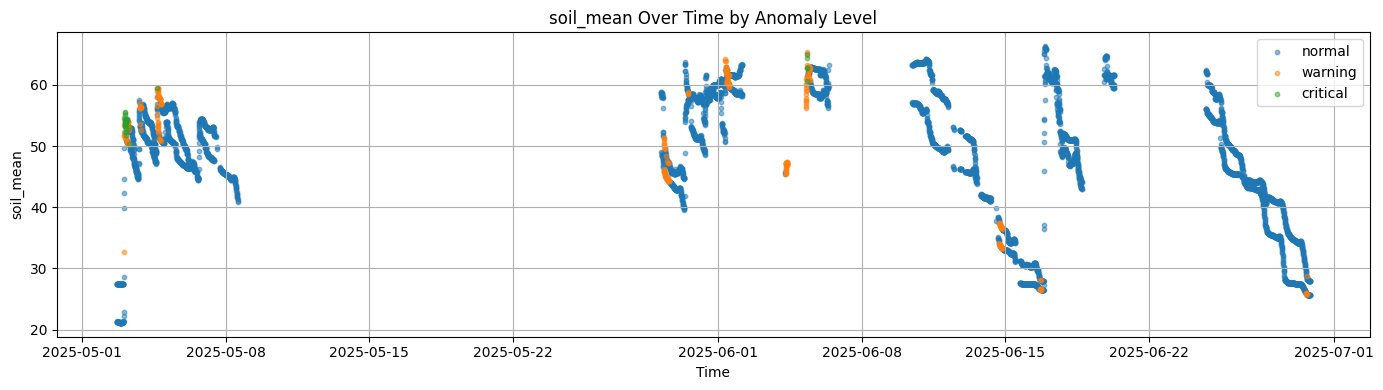

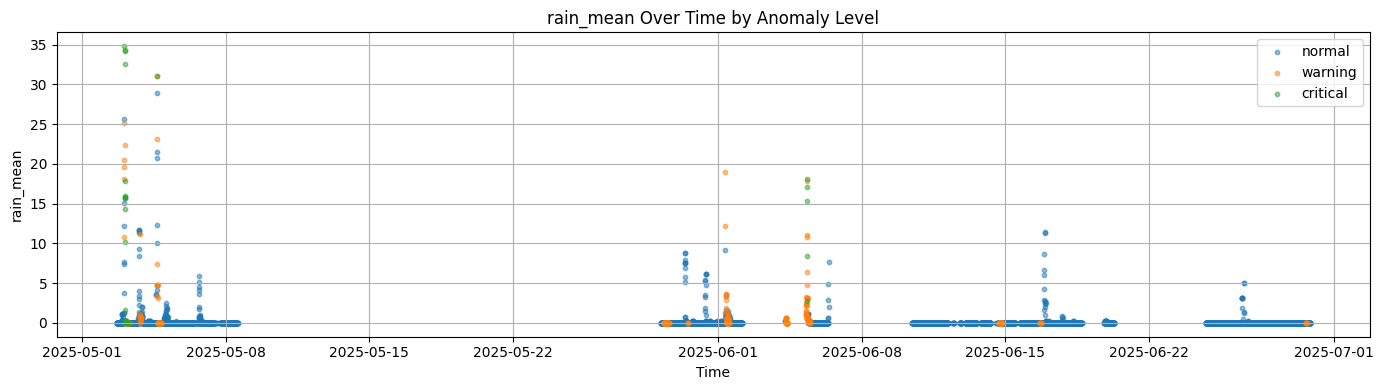

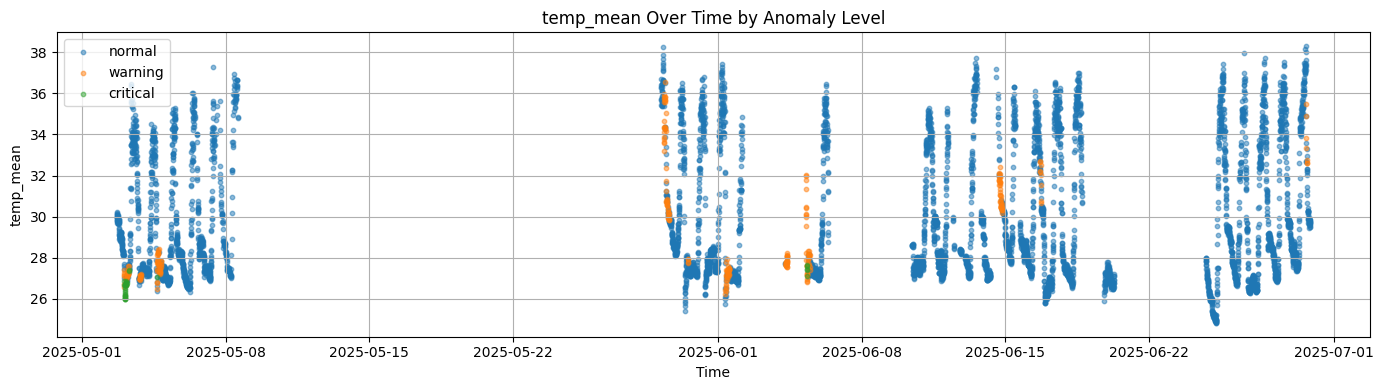

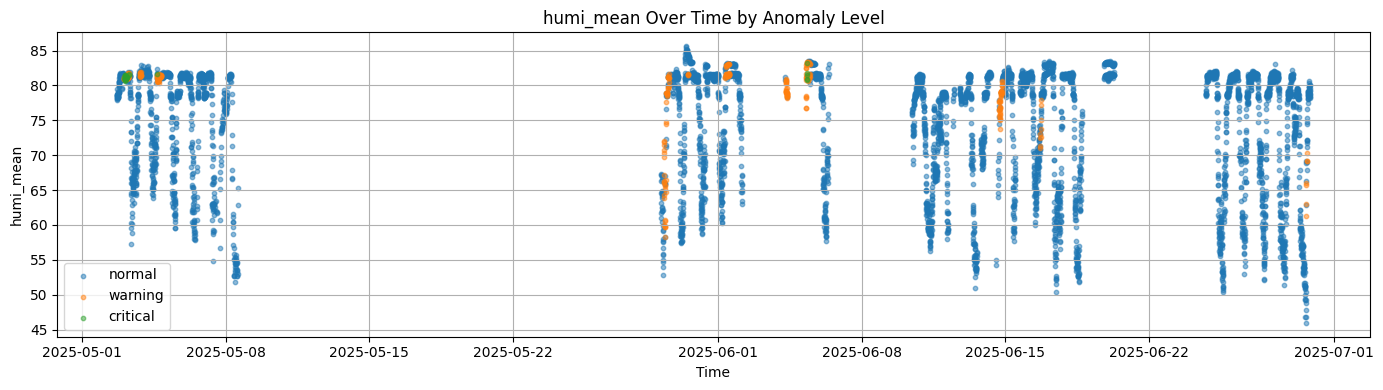

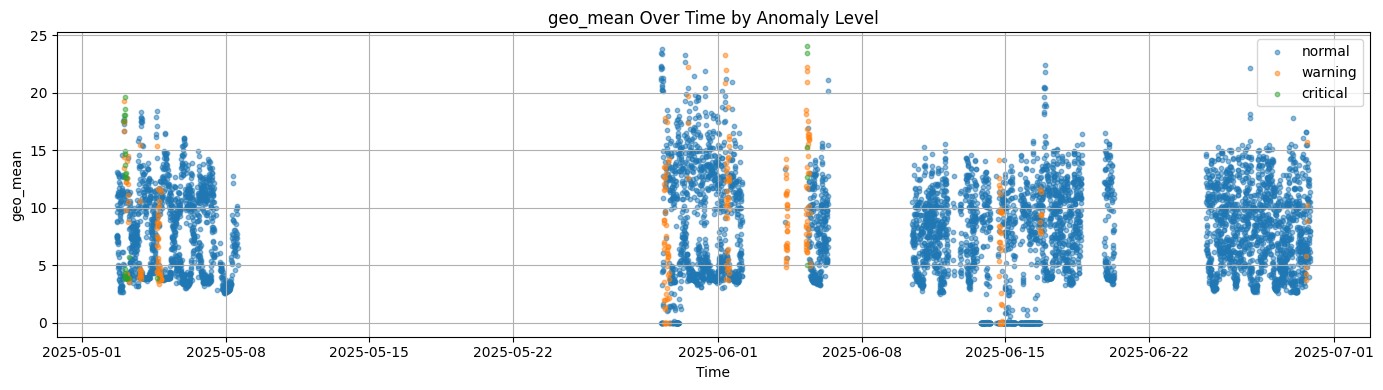

In [161]:
numerical_col_show = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
#numerical_col
for feature in numerical_col_show:
    plt.figure(figsize=(14, 4))
    for level in ['normal', 'warning', 'critical']:
        subset = df_results[df_results['anomaly_level'] == level]
        plt.scatter(subset['timestamp'], df_original_features.loc[subset['original_df_index'], feature],
                    label=level, alpha=0.5, s=10)
    plt.title(f'{feature} Over Time by Anomaly Level')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

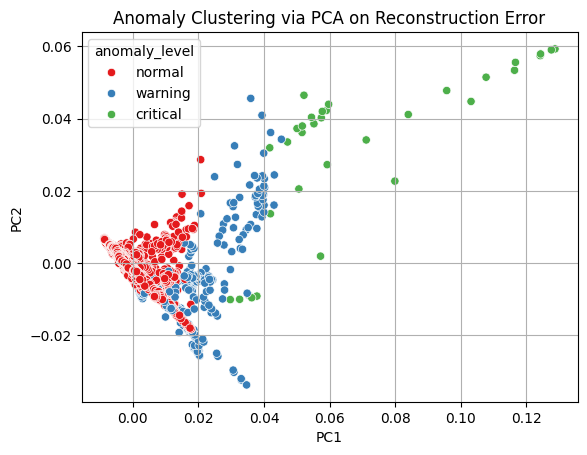

In [162]:
from sklearn.decomposition import PCA
import seaborn as sns

# สร้าง feature จาก reconstruction error
X_error = np.mean((X_seq_test - X_pred)**2, axis=1)  # shape: (num_samples, seq_len)

# ลดมิติด้วย PCA เพื่อ visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_error)

df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['anomaly_level'] = df_results['anomaly_level']

# วาดกราฟ
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='anomaly_level', palette='Set1')
plt.title("Anomaly Clustering via PCA on Reconstruction Error")
plt.grid(True)
plt.show()



In [163]:
pca_df = pd.DataFrame(pca.components_, columns=numerical_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))


                PC1       PC2
rain_mean  0.661124  0.699764
geo_std    0.587597 -0.560241
geo_mean   0.390397 -0.319248
soil_mean  0.226966  0.107312
temp_mean  0.094273 -0.195816
humi_mean  0.069528 -0.211380


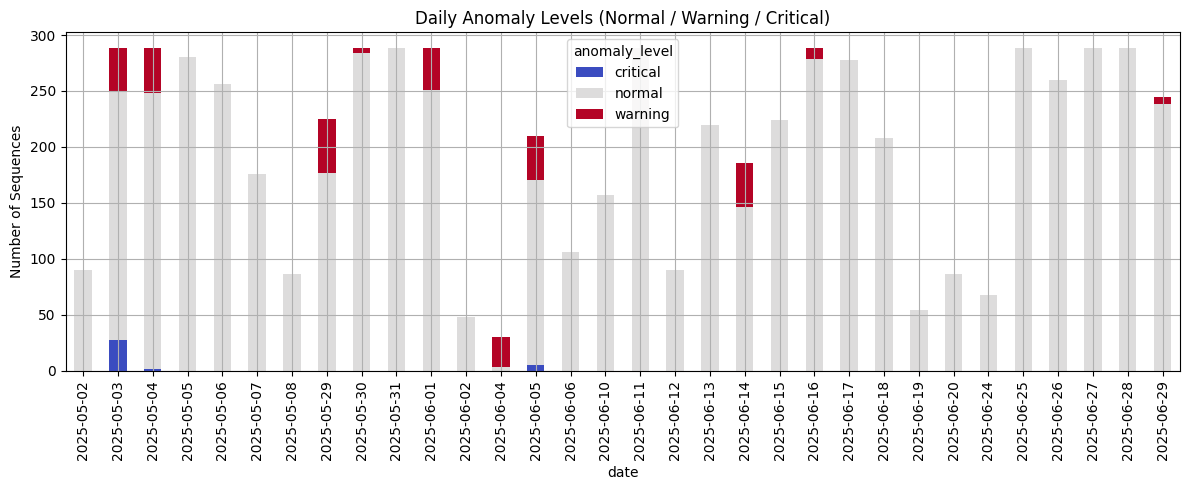

In [164]:
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date
alerts_per_day = df_results.groupby(['date', 'anomaly_level']).size().unstack(fill_value=0)

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='coolwarm')
plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.ylabel("Number of Sequences")
plt.grid(True)
plt.tight_layout()
plt.show()


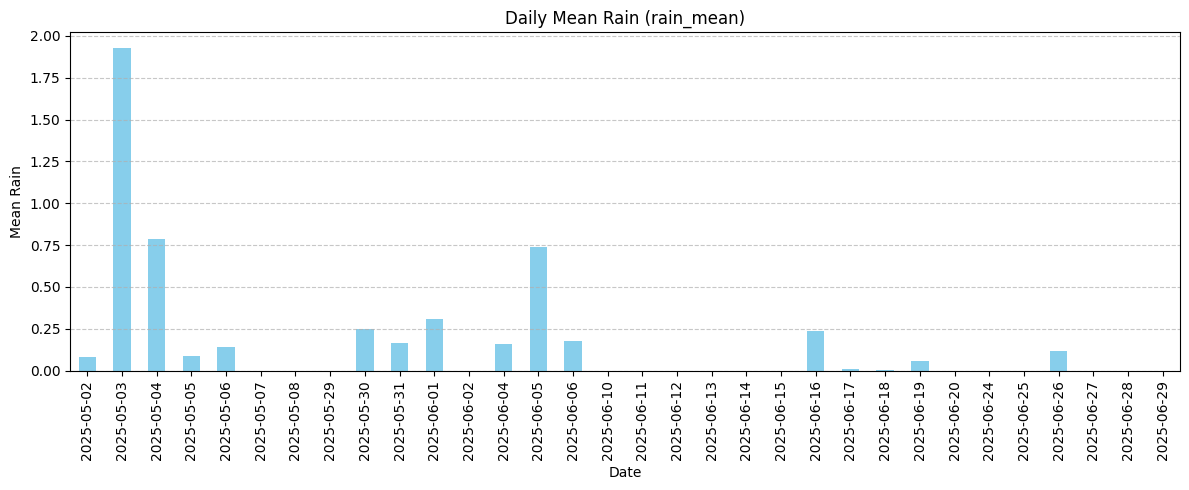

In [165]:
# สร้าง daily mean ของ rain_mean
df_results = df_results.copy()
df_results['rain_mean'] = df_results['original_df_index'].map(df_test['rain_mean'])
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# คำนวณค่าเฉลี่ย rain_mean ต่อวัน
daily_rain = df_results.groupby('date')['rain_mean'].mean()

# วาด bar plot
plt.figure(figsize=(12, 5))
daily_rain.plot(kind='bar', color='skyblue')
plt.title("Daily Mean Rain (rain_mean)")
plt.ylabel("Mean Rain")
plt.xlabel("Date")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


จำนวน critical anomalies ในวันที่ [datetime.date(2025, 5, 2), datetime.date(2025, 5, 3), datetime.date(2025, 5, 4)]: 28


,devID,timestamp,reconstruction_error,original_df_index
54,101,2025-05-03 01:30:00,0.017011,166
55,101,2025-05-03 01:40:00,0.019097,168
56,101,2025-05-03 01:50:00,0.020715,170
57,101,2025-05-03 02:00:00,0.021745,172
58,101,2025-05-03 02:10:00,0.022200,175
59,101,2025-05-03 02:20:00,0.022240,177
60,101,2025-05-03 02:30:00,0.022004,179
61,101,2025-05-03 02:40:00,0.021162,180
62,101,2025-05-03 02:50:00,0.019951,182
63,101,2025-05-03 03:00:00,0.018427,184



จำนวน warning anomalies ในวันที่ [datetime.date(2025, 5, 2), datetime.date(2025, 5, 3), datetime.date(2025, 5, 4)]: 79


,devID,timestamp,reconstruction_error,original_df_index
53,101,2025-05-03 01:20:00,0.010439,164
64,101,2025-05-03 03:10:00,0.016810,187
65,101,2025-05-03 03:20:00,0.015112,188
66,101,2025-05-03 03:30:00,0.012650,190
67,101,2025-05-03 03:40:00,0.010538,192
...,...,...,...,...
3465,102,2025-05-04 20:00:00,0.012684,677
3466,102,2025-05-04 20:10:00,0.013918,678
3467,102,2025-05-04 20:20:00,0.014376,681
3468,102,2025-05-04 20:30:00,0.013072,682


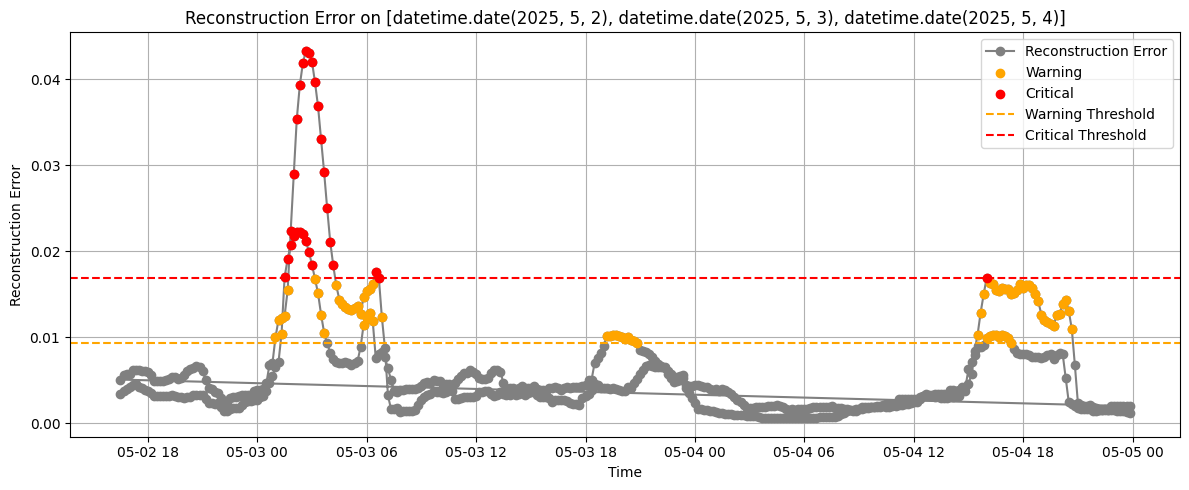

ค่า features ของ sequence critical ในวันนั้น:


,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean
166,2025-05-03 01:30:00,101,54.526001,34.802064,26.870298,81.014650,18.033285
168,2025-05-03 01:40:00,101,55.382353,10.162490,26.654713,81.318445,17.515644
170,2025-05-03 01:50:00,101,55.592156,14.364447,25.968125,81.566479,19.619281
172,2025-05-03 02:00:00,101,55.078000,15.646400,25.987328,81.532236,18.572353
175,2025-05-03 02:10:00,101,54.246000,15.646400,26.152834,81.415466,18.084486
177,2025-05-03 02:20:00,101,53.672549,15.860059,26.208349,81.355434,14.721976
179,2025-05-03 02:30:00,101,53.287754,15.925800,26.339469,81.256539,14.969098
180,2025-05-03 02:40:00,101,53.051999,1.592580,26.649355,80.960938,12.972483
182,2025-05-03 02:50:00,101,52.739999,0.251460,26.677927,81.102504,13.726042
184,2025-05-03 03:00:00,101,52.388235,0.279400,26.821007,80.941869,12.582649


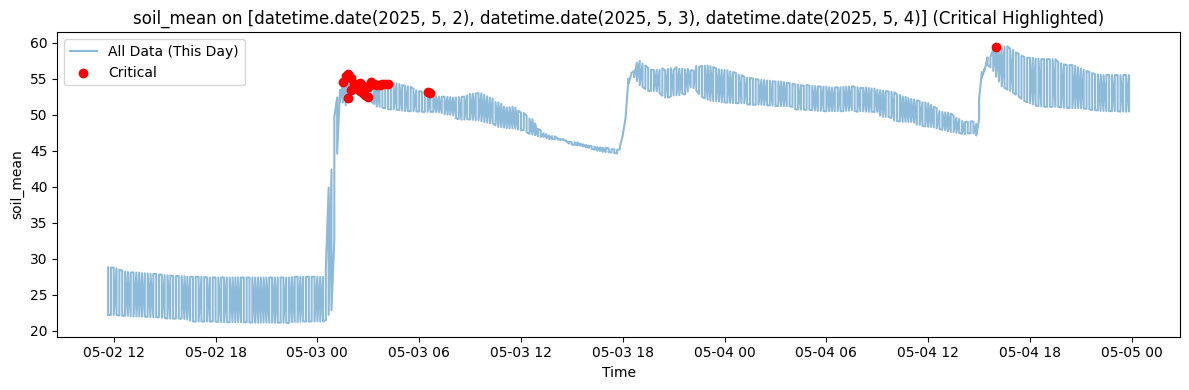

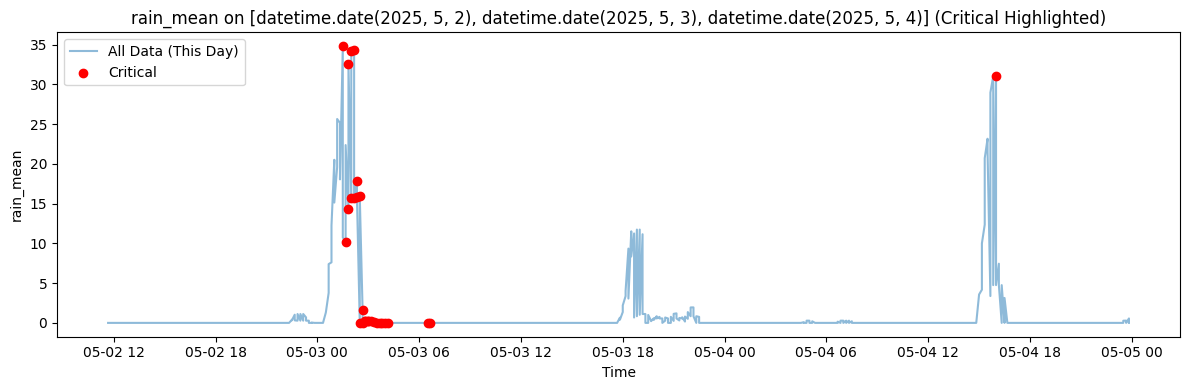

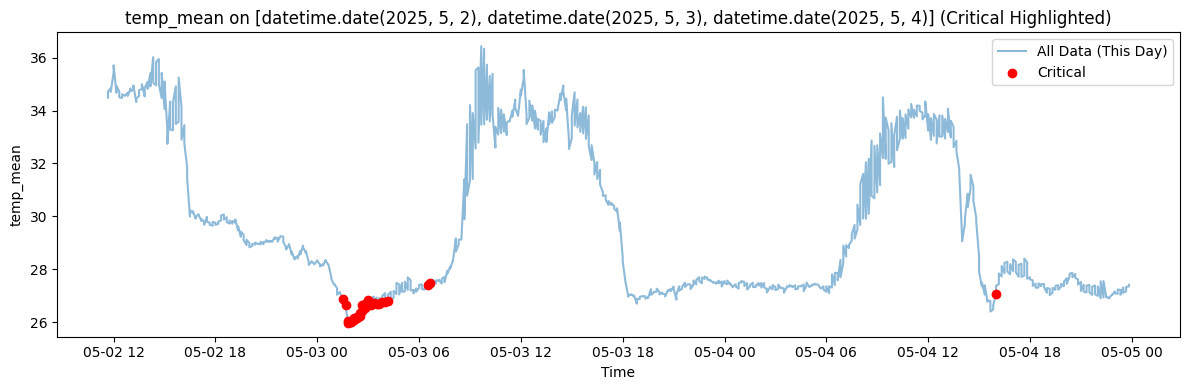

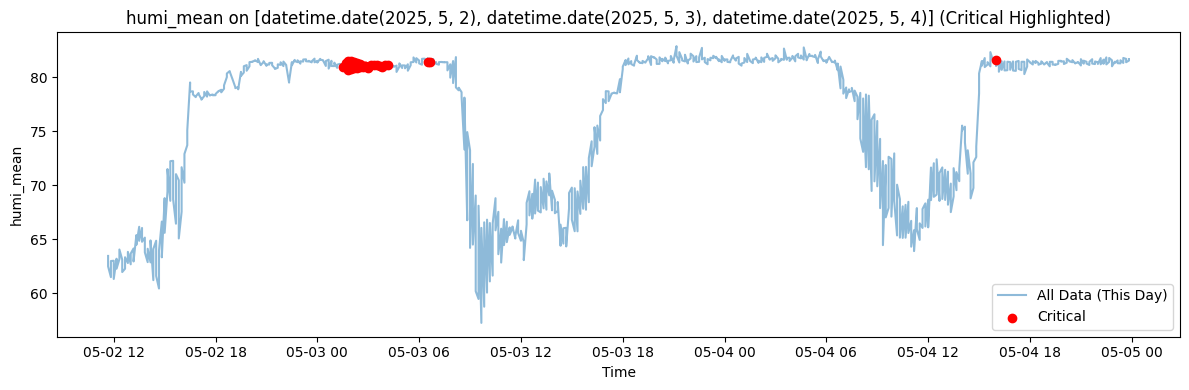

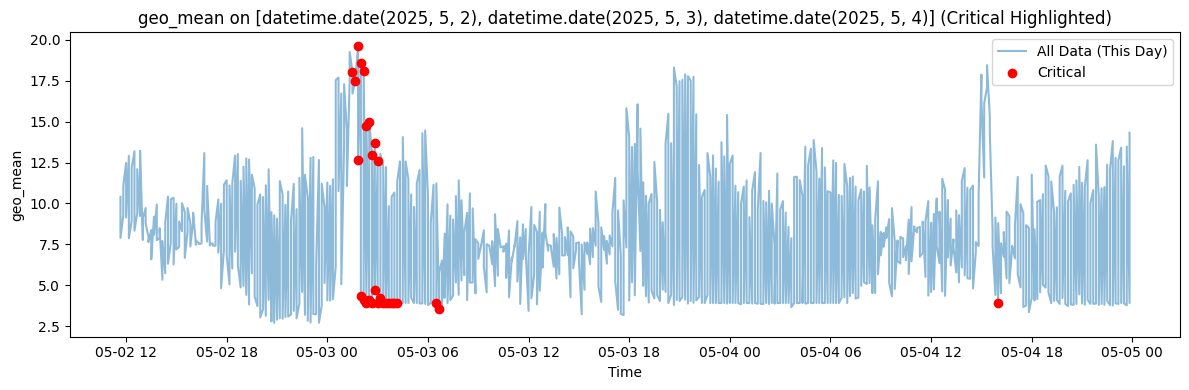

In [166]:
from IPython.display import display

# เลือกเฉพาะวันที่ 15 ถึง 18 มิ.ย. 2025
dates_of_interest = [pd.to_datetime(f'2025-05-{day:02d}').date() for day in range(2, 5)]
# กรองข้อมูลตามวันที่ที่สนใจ
mask_date = df_results['timestamp'].dt.date.isin(dates_of_interest)

# แยกกรณี critical
critical_on_date = df_results[
    mask_date & (df_results['anomaly_level'] == 'critical')
]

# แยกกรณี warning
warning_on_date = df_results[
    mask_date & (df_results['anomaly_level'] == 'warning')
]

print(f"จำนวน critical anomalies ในวันที่ {dates_of_interest}: {len(critical_on_date)}")
display(critical_on_date[['devID', 'timestamp', 'reconstruction_error', 'original_df_index']])

print(f"\nจำนวน warning anomalies ในวันที่ {dates_of_interest}: {len(warning_on_date)}")
display(warning_on_date[['devID', 'timestamp', 'reconstruction_error', 'original_df_index']])

# ถ้ามี anomalies ให้ plot
if not (critical_on_date.empty and warning_on_date.empty):
    plt.figure(figsize=(12, 5))
    
    # เส้นหลักของ reconstruction error
    plt.plot(
        df_results.loc[mask_date, 'timestamp'],
        df_results.loc[mask_date, 'reconstruction_error'],
        label='Reconstruction Error', marker='o', color='gray'
    )
    
    # จุด warning
    if not warning_on_date.empty:
        plt.scatter(
            warning_on_date['timestamp'],
            warning_on_date['reconstruction_error'],
            color='orange', label='Warning', zorder=10
        )
    
    # จุด critical
    if not critical_on_date.empty:
        plt.scatter(
            critical_on_date['timestamp'],
            critical_on_date['reconstruction_error'],
            color='red', label='Critical', zorder=10
        )
    
    # Threshold เส้น
    plt.axhline(y=threshold_warning, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(y=threshold_critical, color='red', linestyle='--', label='Critical Threshold')

    plt.title(f'Reconstruction Error on {dates_of_interest}')
    plt.xlabel('Time')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("ไม่พบ anomalies ในวันที่นี้")

idxs = critical_on_date['original_df_index'].values
features_to_show = numerical_col_show  # ตัวแปรนี้คุณต้องกำหนดไว้ เช่น ['soil_mean', 'rain_mean', ...]

feature_df = df_test.loc[idxs, ['timestamp', 'devID'] + features_to_show]
print("ค่า features ของ sequence critical ในวันนั้น:")
display(feature_df)
# วาดกราฟแสดงค่าของแต่ละ feature
for feature in features_to_show:
    plt.figure(figsize=(12, 4))
    mask_date = df_test['timestamp'].dt.date.isin(dates_of_interest)
    
    plt.plot(
        df_test.loc[mask_date, 'timestamp'],
        df_test.loc[mask_date, feature],
        label='All Data (This Day)', alpha=0.5
    )
    plt.scatter(
        feature_df['timestamp'],
        feature_df[feature],
        color='red', label='Critical', zorder=10
    )
    plt.title(f"{feature} on {dates_of_interest} (Critical Highlighted)")
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()